<a href="https://colab.research.google.com/github/n-nick-2511/DeepLearning2sem/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL

**Выполнять задание следует с текущими значениями гиперпараметров. Для проверки ниже будут приведены ответы, которые должны получиться в результате выполнения задания.**

После того, как заявленные значения совпадут и будут получены работающие модели выполните следующие задания:

1. **Базовая часть (3 балла):** исследуйте влияние параметров `gamma, lr_rate, epsilon` на обучение моделей. Постройте графики.
2. **Опциональная часть (+2 балла):** Реализуйте остальные стратегии выбора действий (softmax, UCB, оптимистичные начальные оценки), описанные в лекции. Визуализируйте результаты.

Зададим гиперпараметры модели

In [1]:
epsilon = 0.1 # Параметр эпсилон при использовании эпсилон жадной стратегии
gamma = 0.8 # Коэффциент дисконтирования гамма
random_seed = 100 #Random seed
time_delay = 1 # Задержка времени при отрисовке процесса игры после обучения (секунды)
lr_rate = 0.9 #Коэффициент скорости обучения альфа

Импортируем библиотеки, создаем свою среду размера 6х6. S обозначает точку старта. F -- лед безопасен, H -- проталина, G -- цель. Параметр `is_slippery=False` отвечает за условное отсутствие скольжения. То есть если агент выбрал действие пойти направо, то он переместится в соответствующее состояние. В общем случае из-за "скольжения" можно оказаться в другом состоянии. Мы также скопировали из библиотки GYM и слегка модифицировали функцию ```generate_random_map ```, для того, чтобы генерировать произвольные карты на основе ```random_seed ```.





In [2]:
# Установим нужную версию библиотеки gym
!git clone https://github.com/dvolchek/gym_0_18_0.git -q
%cd /content/gym_0_18_0
!pip install -e. -q

/content/gym_0_18_0
  Preparing metadata (setup.py) ... done


In [3]:
import gym
import numpy as np
import time
from IPython.display import clear_output


def generate_random_map(size, p, sd):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False
    np.random.seed(sd)

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

#Генерация карты
random_map = generate_random_map(size=6, p=0.8, sd = random_seed) #Создаем свою карту
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) #Инициализируем среду
print("Ваша карта")
env.render() #Выводим карту на экран

Ваша карта

SFFHFF
FHFFHF
FFFHHF
HFFHHF
FFFFFF
FFFFFG


Функции выбора действия и обновления таблицы ценности действий. Строчка *** используется для того, чтобы проверять ответы в openedx. Вне рамках академической задачи лучше использовать оригинальный метод класса `environment`, то есть:

`action = env.action_space.sample()`

# Задача 1
Дополните функцию ```learn()```, чтобы в результате ее вызова обновлялось значение ценности текущего действия согласно алгоритму Q-обучения



In [5]:
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, state2, reward, action, done):
    predict = Q[state, action]
    if done:
        target = reward
    else:
        target = reward + gamma * np.max(Q[state2, :])
    Q[state, action] += lr_rate * (target - predict)

# Задача 2
Дополните следующий код так, чтобы в результате обучения модели можно было узнать количество побед и номер игры (`game`), на котором агент впервые одержал пятую победу подряд.

Поясним, что возвращает функция ```env.step(action)```

```state2``` -- следующее состояние

```reward``` -- награда

```done``` -- флаг окончания игры. True в случае победы или падения в проталину. False в остальных случаях.




In [10]:
from tqdm import tqdm

# Inititalization
np.random.seed(random_seed)
total_games = 10000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))

# Счётчики
total_wins = 0  # Общее число побед
consecutive_wins = 0 # Текущая серия побед
first_game_with_5_wins = None # Номер игры, где было впервые достигнуто 5 побед подряд

#Main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    done = False

    while t < max_steps:
        t += 1
        action = choose_action(state)
        state2, reward, done, info = env.step(action)

        if t == max_steps:
            done = True

        learn(state, state2, reward, action, done)

        state = state2

        if done:
            if reward == 1.0:  # Победа
                total_wins += 1
                consecutive_wins += 1
                if consecutive_wins == 5 and first_game_with_5_wins is None:
                    first_game_with_5_wins = game + 1
            else:  # Поражение
                consecutive_wins = 0
            break



100%|██████████| 10000/10000 [00:06<00:00, 1455.25it/s]


Вывод ответов при заданных параметрах

In [11]:
print("Количество побед в серии из 10 000 игр: ", total_wins)
print("Пять побед подряд впервые было одержано в игре ", first_game_with_5_wins)


Количество побед в серии из 10 000 игр:  7914
Пять побед подряд впервые было одержано в игре  885


Должны получиться следующие результаты.


*  Количество побед в серии из 10 000 игр:  7914
*  Пять побед подряд впервые было одержано в игре  885




Произведем одну игру, чтобы проследить за действиями агента. При этом будем считать модель полностью обученной, то есть действия выбираются жадно, значения ценностей действий в таблице не обновляются.

In [12]:
import time
#Жадный выбор действий
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

states=[]#Массив для сохранения состояний агента в течение игры
t = 0
state = env.reset()
wn = 0
while(t<100):
  env.render()
  time.sleep(time_delay)
  clear_output(wait=True)
  action = choose_action_one_game(state)
  state2, reward, done, info = env.step(action)
  states.append(state)
  state = state2
  t += 1
  if done and reward == 1:
    wn=1
  if done:
    break
if wn == 1:
  print("!!!Победа!!!")

!!!Победа!!!


Отобразим маршрут

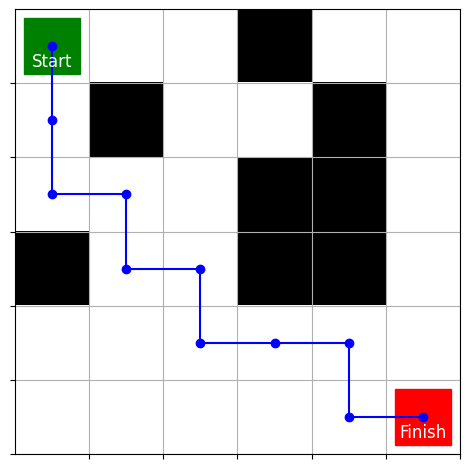

In [13]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic=[]
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic


#Make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

#Arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
if wn == 1:
  rw = np.append(rw, [nrows-1])
  cl = np.append(cl,[ncols-1])

#Picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")

# Задача 3

Используйте вместо алгоритма Q-обучения алгоритм SARSA. Обратите внимание на то, что требуется изменить количество игр. То есть `total_games = 40000`. Запускать блоки следует последвательно с самого начала (из-за `random_seed`). Отдельно обращаем ваше внимание на то, что при изменении алгоритма с Q-обучения на SARSA модификации подлежит как процесс обучения, так и функция `learn()`. Кроме того, у функции `learn()` должен появиться дополнительный аргумент (следующее действие). Ниже приведен фрагмент кода с пояснениями, как именно нужно модифицировать алгоритм.



In [14]:
def choose_action(state):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, env.action_space.n)
    else:
        return np.random.choice(np.flatnonzero(Q[state, :] == np.max(Q[state, :])))


In [15]:
def learn(state, state2, reward, action, action2, done):
    predict = Q[state, action]
    target = reward if done else reward + gamma * Q[state2, action2]
    Q[state, action] = Q[state, action] + lr_rate * (target - predict)


In [17]:
from tqdm import tqdm
np.random.seed(random_seed)
total_games = 40000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))

total_wins = 0
consecutive_wins = 0
first_5_wins_game = None

for game in tqdm(range(total_games)):
    state = env.reset()
    action = choose_action(state)

    for t in range(max_steps):
        state2, reward, done, _ = env.step(action)
        action2 = choose_action(state2)

        if t == max_steps - 1:
            done = True

        learn(state, state2, reward, action, action2, done)

        state = state2
        action = action2

        if done:
            if reward == 1:
                total_wins += 1
                consecutive_wins += 1
                if consecutive_wins == 5 and first_5_wins_game is None:
                    first_5_wins_game = game + 1
            else:
                consecutive_wins = 0
            break


100%|██████████| 40000/40000 [00:32<00:00, 1214.59it/s]


In [19]:
print("Количество побед в серии из 40 000 игр: ", total_wins)
print("Пять побед подряд впервые было одержано в игре ", first_5_wins_game)

Количество побед в серии из 40 000 игр:  32328
Пять побед подряд впервые было одержано в игре  894


. В результате обучения должны получиться следующие ответы:



*   Количество побед в серии из 40 000 игр:  32328
*   Пять побед подряд впервые было одержано в игре  894

## Исследование влияния параметров

In [27]:
def run_sarsa(gamma=0.8, lr_rate=0.9, epsilon=0.1, total_games=40000, max_steps=100):
    np.random.seed(random_seed)
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    win_count = 0
    game_5wins = None

    for game in range(total_games):
        state = env.reset()
        action = choose_action(state)
        for t in range(max_steps):
            state2, reward, done, _ = env.step(action)
            action2 = choose_action(state2)

            learn(state, state2, reward, action, action2, done)

            state, action = state2, action2

            if done and reward == 1:
                win_count += 1
                break

    return win_count


Исследование параметра 'gamma':
  Тест 1/6: gamma = 0.1
  Тест 2/6: gamma = 0.3
  Тест 3/6: gamma = 0.5
  Тест 4/6: gamma = 0.7
  Тест 5/6: gamma = 0.9
  Тест 6/6: gamma = 0.99
Завершено исследование параметра 'gamma'.



<ipython-input-28-1768801144>:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper right')


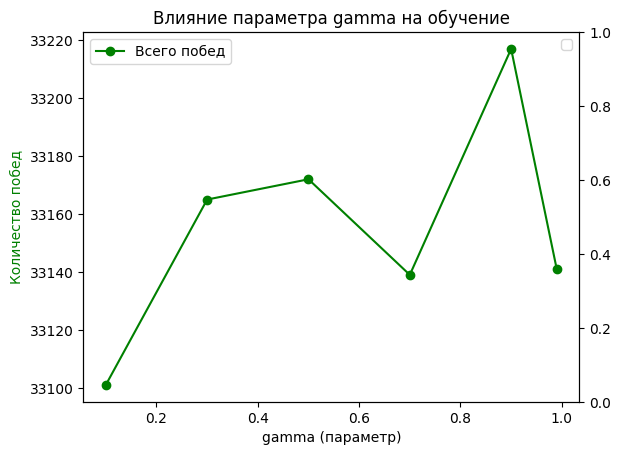

Исследование параметра 'lr_rate':
  Тест 1/6: lr_rate = 0.1
  Тест 2/6: lr_rate = 0.3
  Тест 3/6: lr_rate = 0.5
  Тест 4/6: lr_rate = 0.7
  Тест 5/6: lr_rate = 0.9
  Тест 6/6: lr_rate = 0.99
Завершено исследование параметра 'lr_rate'.



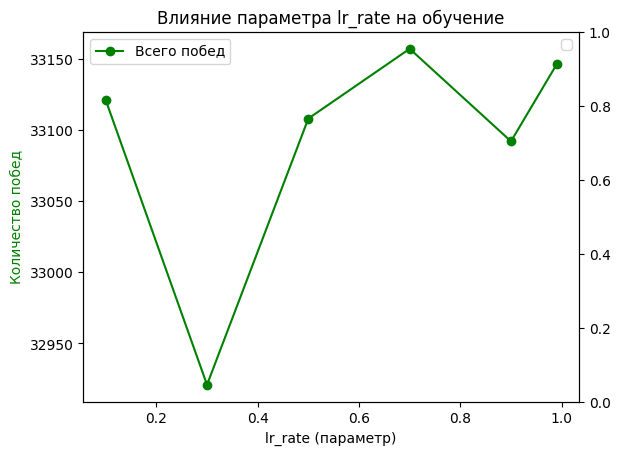

Исследование параметра 'epsilon':
  Тест 1/6: epsilon = 0.01
  Тест 2/6: epsilon = 0.05
  Тест 3/6: epsilon = 0.1
  Тест 4/6: epsilon = 0.2
  Тест 5/6: epsilon = 0.3
  Тест 6/6: epsilon = 0.5
Завершено исследование параметра 'epsilon'.



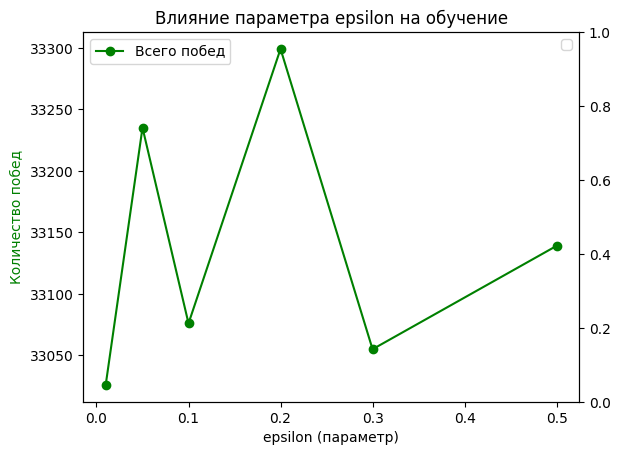

In [28]:
import matplotlib.pyplot as plt

def test_param_range(param_name, values):
    results = []

    print(f"Исследование параметра '{param_name}':")
    for i, val in enumerate(values, 1):
        print(f"  Тест {i}/{len(values)}: {param_name} = {val}")
        kwargs = {'gamma': 0.8, 'lr_rate': 0.9, 'epsilon': 0.1}
        kwargs[param_name] = val
        wins = run_sarsa(**kwargs)
        results.append((val, wins))

    print(f"Завершено исследование параметра '{param_name}'.\n")
    return results

def plot_results(results, param_name):
    x = [r[0] for r in results]
    wins = [r[1] for r in results]

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(x, wins, 'g-', marker='o', label='Всего побед')

    ax1.set_xlabel(f'{param_name} (параметр)')
    ax1.set_ylabel('Количество побед', color='g')
    ax1.set_title(f'Влияние параметра {param_name} на обучение')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()

# Исследуем gamma
gamma_values = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
results_gamma = test_param_range('gamma', gamma_values)
plot_results(results_gamma, 'gamma')

# Исследуем lr_rate
lr_values = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
results_lr = test_param_range('lr_rate', lr_values)
plot_results(results_lr, 'lr_rate')

# Исследуем epsilon
epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
results_eps = test_param_range('epsilon', epsilon_values)
plot_results(results_eps, 'epsilon')


## Сравнение разных стратегий

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def run_sarsa(strategy_type, total_games=20000, epsilon=0.1, tau=1.0, c_param=1.0, initial_q=0.0):
    Q_table = np.full((env.observation_space.n, env.action_space.n), initial_q)
    action_counts = np.zeros_like(Q_table)  # для UCB
    game_rewards = []

    for game in tqdm(range(total_games), desc=f"Тренировка: {strategy_type}"):
        state = env.reset()
        total_reward = 0

        for step in range(100):
            if strategy_type == "epsilon_greedy":
                if np.random.random() < epsilon:
                    action = np.random.randint(env.action_space.n)
                else:
                    max_q = Q_table[state].max()
                    action = np.random.choice(np.flatnonzero(Q_table[state] == max_q))

            elif strategy_type == "softmax":
                prefs = Q_table[state] / tau
                exp_prefs = np.exp(prefs - np.max(prefs))
                probabilities = exp_prefs / exp_prefs.sum()
                action = np.random.choice(env.action_space.n, p=probabilities)

            elif strategy_type == "ucb":
                total_visits = np.sum(action_counts[state]) + 1e-8
                ucb_scores = Q_table[state] + c_param * np.sqrt(np.log(total_visits) / (action_counts[state] + 1e-8))
                action = np.argmax(ucb_scores)

            elif strategy_type == "optimistic":
                max_q = Q_table[state].max()
                action = np.random.choice(np.flatnonzero(Q_table[state] == max_q))

            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Обновление Q-таблицы
            alpha = 0.9
            gamma = 0.8
            td_target = reward + gamma * np.max(Q_table[next_state])
            Q_table[state, action] += alpha * (td_target - Q_table[state, action])

            if strategy_type == "ucb":
                action_counts[state, action] += 1

            state = next_state
            if done:
                break

        game_rewards.append(total_reward)

    avg_rewards = np.cumsum(game_rewards) / (np.arange(len(game_rewards)) + 1)
    return avg_rewards




Тренировка: ucb:   0%|          | 0/20000 [00:00<?, ?it/s]<ipython-input-55-576022550>:30: RuntimeWarning: invalid value encountered in sqrt
  ucb_scores = Q_table[state] + c_param * np.sqrt(np.log(total_visits) / (action_counts[state] + 1e-8))
Тренировка: optimistic: 100%|██████████| 20000/20000 [00:02<00:00, 8754.14it/s]


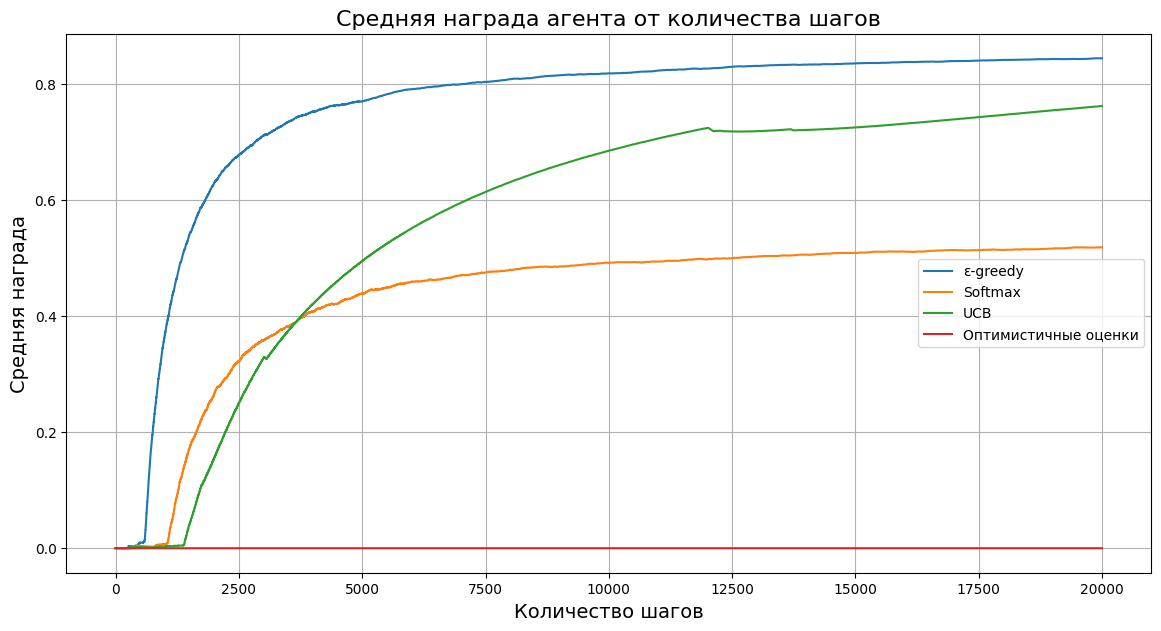

In [56]:
# Параметры стратегий
strategies_params = {
    "ε-greedy": {"strategy_type": "epsilon_greedy", "epsilon": 0.1},
    "Softmax": {"strategy_type": "softmax", "tau": 0.1},
    "UCB": {"strategy_type": "ucb", "c_param": 2.0},
    "Оптимистичные оценки": {"strategy_type": "optimistic", "initial_q": 5.0},
}

results = {}
for name, params in strategies_params.items():
    results[name] = run_sarsa(**params)

# Визуализация
plt.figure(figsize=(14, 7))
for label, data in results.items():
    plt.plot(data, label=label)

plt.title("Средняя награда агента от количества шагов", fontsize=16)
plt.xlabel("Количество шагов", fontsize=14)
plt.ylabel("Средняя награда", fontsize=14)
# plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()
